#MC886 - Trabalho 1 
RA217555 Gustavo Praciano Barros
RA217878 Hitalo Cesar Alves

##Funções auxiliares

In [219]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

In [220]:
def dist(p1, p2):
    sum=0
    for i in range(len(p1)):
        sum+=(p1[i]-p2[i])**2
    return sum**0.5

In [221]:
def normalize(data):
    dataN = []
    maxArray = []
    for i in range(len(data[0])):
      dataN.append([j[i] for j in data])
    dataN = np.array(dataN)
    dataN.astype(float)
    for i in range(len(dataN)):
      maxArray.append(max(abs(max(dataN[i])), abs(min(dataN[i]))))
      dataN[i] = dataN[i]/maxArray[i]

    return dataN.transpose(), np.array(maxArray) 

In [222]:
def unnormalize(dataNormalized, maxAxis):
    dataNormalized = np.array(dataNormalized)
    for i in range(len(dataNormalized)):
        dataNormalized[i] = dataNormalized[i] * maxAxis
    return dataNormalized

In [223]:
def plotClusters(clusters):
    k = len(clusters)
    cores = ['red','green','blue','black','brown', 'pink']
    for i in range(0,k):
        x = np.array([j[0] for j in clusters[i]])
        y = np.array([j[1] for j in clusters[i]])
        plt.scatter(x, y, c=cores[i])

In [224]:
def data_part(data, treino, teste):
  data = np.random.permutation(data)
  tr = data[:int(len(data)*treino)]
  te = data[int(len(data)*treino):len(data)]
  return tr, te
   


##Leitura dos dados, normalização e separação conjunto de treinamento e de testes

###Dados enunciado

In [225]:
def read_data_enun():
  datContent = np.array([i.strip().split() for i in open("./cluster.dat").readlines()])
  datContent = datContent.astype(np.float)
  return datContent

In [226]:
datContent_normalized, maxAxis_enun = normalize(read_data_enun())
data_training_enun,data_test_enun = data_part(datContent_normalized, 0.9,0.1)

###Dados dataset escolhido

  O dataset escolhido para realizar o trabalho é um dataset com informações referentes ao uso de cartões de créditos de 9000 pessoas no intervalo de 6 meses. Pensando nisso, queremos clusterizar as pessoas de acordo com seu uso de cartão. 
  No dataSet tem 18 features, entretanto optamos em escolher 9 features que são mais impactantes na clusterização. Ademais, tivemos que limpar alguns dados que estavam incompletos. Caso tenha interesse na fonte dados, segue o link abaixo.
   https://www.kaggle.com/arjunbhasin2013/ccdata
  Esse código a seguir, tem como intuito simplesmente ler o csv e colocar na lista de dados.

In [227]:
import csv
import numpy as np

with open('DataSetFiltradoCortado.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)
for i in range(0,len(data)):
  for j in range(0, len(data[i])):
    if(data[i][j] == ''):
        data[i][j] = '0' 
    data[i][j] = float(data[i][j])

data_normalized_chosen, maxAxis_chosen = normalize(data)
data_normalized_chosen = data_normalized_chosen[0:2000]

data_training_chosen,data_test_chosen = data_part(data_normalized_chosen, 0.9,0.1)


##K-means

###Implementação KMeans

In [228]:
def menorDist(centros, p):
    min = [0,dist(p,centros[0])]
    for i in range(1,len(centros)):
        disti = dist(p,centros[i])
        if(min[1] > disti):
            min = [i, disti]
    return min[0]

Programa para identificar o novo centro no método fazendo as médias dos clusters dados.

In [229]:
def novoCentroMetodo(pontos):
  n = len(pontos)
  centro = np.array([0.0 for i in range(len(pontos[0]))])
  for i in range(0, n):
      centro += pontos[i]
  if n == 0:
    return np.array([0.0 for i in range(len(pontos[0]))])
  return centro/n

####Inicialização

Foram implementadas 3 formas diferentes de inicialização. 

A primeira random_dist faz a inicialização utilizando pontos aleatorios com probabilidade ponderada proporcional à distancia do ponto(quanto maior a distância maior a probabilidade)

A segunda função random_dist_selected que é a que escolhemos utilizar efetivamente no algoritmo faz a mesma coisa da função anterior, porém são considerados apenas 20% dos pontos, sendo esses os pontos mais provaveis. E ainda assim mantendo a probabilidade proporcional à distancia.

A terceira função max_dist é a mais elementar, ela simplismente define os pontos de inicialização tomando os pontos mais distantes.


In [230]:
def random_dist(p, data):
    d = np.array([dist(p, i) for i in data])
    s = d.sum()
    p = [i/s for i in d]
    rand = np.random.random()
    r = 0
    for i in range(len(p)):
        r+=p[i]
        if r >= rand:
            return data[i]
    return -1

In [231]:
def random_dist_selected(p, data):
    npontos = int(len(data)*0.2)
    d = np.array([dist(p, i) for i in data])
    idxs = []
    dists = []
    for i in range(npontos):
        m = max(d)
        id = list(d).index(m)
        d[id] = -1
        idxs.append(id)
        dists.append(m)

    s = sum(dists)
    p = [i/s for i in dists]
    rand = np.random.random()
    r = 0
    for i in range(len(p)):
        r+=p[i]
        if r >= rand:
            return data[idxs[i]]
    return -1

In [232]:
def max_dist(p, data):
    d_max = 0
    p_end = p
    for i in range(len(data)):
        d = dist(p, data[i])
        if d >= d_max:
            d_max = d
            p_end = data[i]
    return p_end

In [233]:
def find_init(data, k):
    ans = []
    idx=np.random.randint(len(data))
    p1 = data[idx]
    ans.append(p1)
    for i in range(k-1):
        center = novoCentroMetodo(ans)
        #ans.append(random_dist(center, data) )  
        ans.append(random_dist_selected(center, data) )  
        #ans.append(max_dist(center, data) )


    return np.array(ans)

####KMeans principal

In [234]:
def kMeans(data, k):
  dim = len(data)
  n = len(data)
  centros = find_init(data, k)
  c_aux = copy.deepcopy(centros[:])
  change = 1
  clusters = [[] for i in range(k)]
  novoCentro = 0
  while(change):
      change = 0
      clusters = [[] for i in range(k)]
      for i in range(0,n):
          cluster = menorDist(centros,data[i])
          clusters[cluster].append(data[i].tolist())
      for i in range(0, k):
          novoCentro = novoCentroMetodo(clusters[i])
          if(not np.array_equal(centros[i], novoCentro)):
              centros[i] = novoCentro
              change = 1
  return clusters, centros, c_aux

###Método do cotovelo
Nessa etapa foi utilizado o método do cotovelo para se estimar o numero k de clusters a se utilizar na execução do algoritmo.

In [235]:
def erro_acumulado(pts, centers):
  s = 0
  for i in range(len(pts)):
    for j in range(len(pts[i])):
      s+=dist(centers[i], pts[i][j])
  return s
  

In [236]:
def metodo_cotovelo_enunciado():
  list_erros=[]
  for i in range(1,10):
    result, centers, c_aux = kMeans(data_training_enun, i)
    list_erros.append((i, erro_acumulado(result, centers)))
  
  plt.scatter(*zip(*list_erros))
  plt.plot(*zip(*list_erros))
  plt.show()

Usando o método do cotovelo com os dados do enunciado.

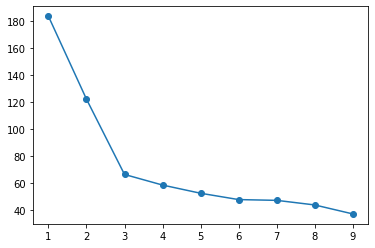

In [237]:
metodo_cotovelo_enunciado()

###KMeans dataset enunciado
Nessa etapa foi feito o treinamento utilizando o dataset separado. E k=3; valor que foi adotado através do método do cotovelo. Além disso é apresentado em preto os pontos de inicialização e em amarelo os pontos centrais dos clusters.

In [238]:
def kmeans_ds_enun():
  result1, centers1, c_aux1 = kMeans(data_training_enun, 3)
  for i in range(0,len(result1)):
    result1[i] = unnormalize(result1[i],maxAxis_enun)
  centers1 = unnormalize(centers1,maxAxis_enun)
  c_aux1 = unnormalize(c_aux1,maxAxis_enun)
  plotClusters(result1)
  for i in range(3):
    plt.scatter(c_aux1[i][0], c_aux1[i][1], color = 'black')
    plt.scatter(centers1[i][0], centers1[i][1], color = 'yellow')
  plt.show()
  return centers1

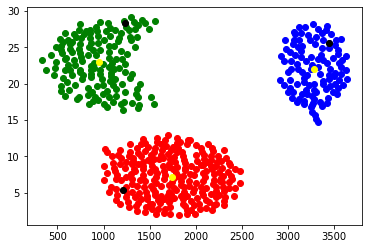

In [239]:
centers1=kmeans_ds_enun()

###KMeans dataset escolhido

####Metodo do cotovelo dataset escolhido

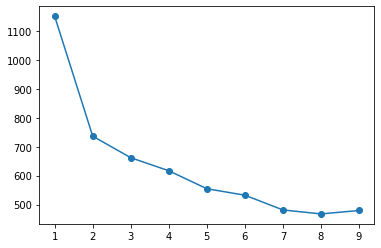

In [240]:
def metodo_cotovelo_escolhido():
  list_erros=[]
  for i in range(1,10):
    result, centers, c_aux = kMeans(data_training_chosen, i)
    list_erros.append((i, erro_acumulado(result, centers)))
  
  plt.scatter(*zip(*list_erros))
  plt.plot(*zip(*list_erros))
  plt.show()

metodo_cotovelo_escolhido()

####Executando KMeans no dataset escolhido


In [241]:
def histograma(result):
  histograma = []
  for i in range(0,len(result)):
    for j in range(0,len(result[i])):
      histograma.append(i)
  plt.hist(histograma)
  plt.show()

In [242]:
def kmeans_ds_chosen():
  result2, centers2, c_aux2 = kMeans(data_training_chosen, 4)
  centers2 = unnormalize(centers2,maxAxis_chosen)
  histograma(result2)
  return centers2

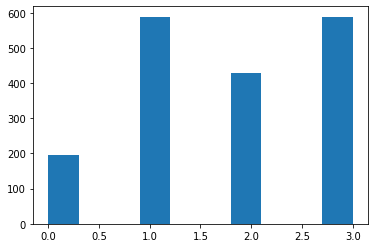

In [243]:
centers2 = kmeans_ds_chosen()

##DBSCAN


###A implementação do algoritmo foi feita de modo a buscar os core points, border points e outiliers. Tendo estes na função dbscan, foi feita a clusterização na função db_clustering. que tendo os tipos de pontos atribui os seus respectivos clusters.



In [244]:
import queue

In [245]:
def db_clustering(l, inran):
  core = -1
  border = -2
  outlier = -3
  rots = []
  aux = []
  for i in range(len(inran) ):
    if i in l[0]:
      rots.append(core)
    elif i in l[1]:
      rots.append(border)
    elif i in l[2]:
      rots.append(outlier)

  cl = 0
  for i in range(len(rots)):
    q = queue.Queue()
    if (rots[i] == core):
      aux.append([])
      rots[i] = cl
      for x in inran[i]:
        if(rots[x]==core):
          q.put(x)
          rots[x]=cl
          aux[-1].append(x)
        elif(rots[x]==border):
          rots[x]=cl
      while not q.empty():
        neighbors = inran[q.get()]
        for y in neighbors:
          if (rots[y]==core):
            rots[y]=cl
            q.put(y)
            aux[-1].append(y)
          if (rots[y]==border):
            rots[y]=cl            
      cl=cl+1

  for i in range(len(rots)):
    if rots[i] == outlier:
      rots[i] = cl

  return rots, aux

In [246]:
def dbscan(data, eps, M):
  core = []
  border = []
  outlier = []
  dists = []
  for i in range(len(data)):
    aux = []
    for j in range(len(data)):
      aux.append(dist(data[i], data[j]))
    dists.append(aux)
  
  inran = []
  for i in range(len(data)):
    pts = []
    for j in range(len(data)):
      if dists[i][j] <= eps:
        pts.append(j)
    if len(pts) >= M:
      core.append(i)
    inran.append(pts)

  for i in range(len(inran)):
    for j in range(len(inran[i])):
      if i not in core and inran[i][j] in core:
        border.append(i)
        break

  for i in range(len(inran)):
    if i not in core and i not in border:
      outlier.append(i)

  r, cs = db_clustering([core,border,outlier], inran)
  z = max(r)

  ans = [[] for i in range(z+1)]

  for i in range(len(r)):
    ans[r[i]].append(data[i])

  for i in range(len(cs)):
    for j in range(len(cs[i])):
      cs[i][j] = data[cs[i][j]]

  return ans, cs, eps

###Utilizando dbscan no dataset dado no enunciado
A cor preta representa os outliers e as demais cores os clusters.

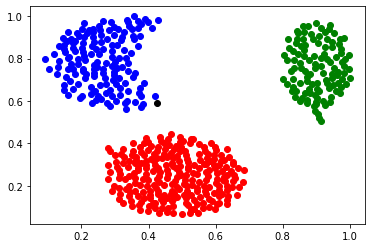

In [247]:
clusters_enun_db, cores_enun, eps_enun = dbscan(data_training_enun, 0.1,30)

plotClusters(clusters_enun_db)

plt.show()

###Utilizando dbscan no dataset escolhido

In [248]:
def main2():
  list_erros=[]
  for i in range(1,10):
    for j in range(1,10):
      result = dbscan(data_normalized_chosen, 0.1*i, 10*j)
      print(i,j,len(result) )
      print("------------------")
#main2()

In [249]:
clusters_chosen, cores_chosen, eps_chosen = dbscan(data_training_chosen, 0.2, 50)

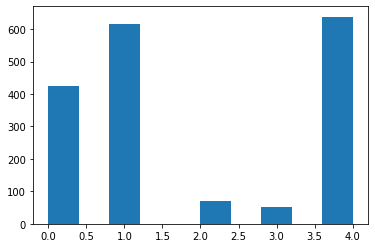

In [250]:
histograma(clusters_chosen)

##PCA

###Aplicando PCA no dataset escolhido

Usamos o PCA para melhorar o trabalho do treinamento e analisarmos seus impactos. Para isso, vamos colocar os dados em 2D e 5D. 

In [251]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
out2d = pca.fit_transform(data_training_chosen)
out2d_test = pca.fit_transform(data_test_chosen)

In [252]:
pca = PCA(n_components=5)
out5d = pca.fit_transform(data_training_chosen)
out5d_test = pca.fit_transform(data_test_chosen)

###Aplicando PCA para 2D

[(1, 993.5037192490774), (2, 522.8443143455611), (3, 438.78671670242176), (4, 304.83956679255004), (5, 296.2026154479056), (6, 263.5610923038089), (7, 248.0598615146159), (8, 228.72733010977169), (9, 211.7388710509105)]


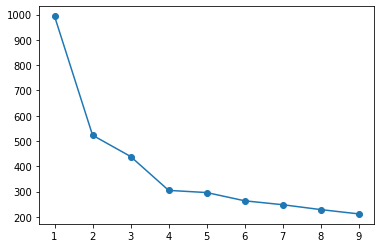

In [253]:
def main3():
  list_erros=[]
  for i in range(1,10):
    result, centers, c_aux = kMeans(out2d, i)
    list_erros.append((i, erro_acumulado(result, centers)))
  
  print(list_erros)
  plt.scatter(*zip(*list_erros))
  plt.plot(*zip(*list_erros))
  plt.show()

main3()

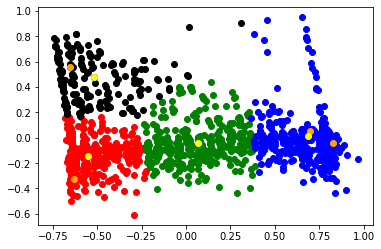

In [254]:
def main3(k):
  result, centers_PCA_2D, c_aux = kMeans(out2d, k)
  plotClusters(result)
  for i in range(k):
    plt.scatter(c_aux[i][0], c_aux[i][1], color = 'orange')
    plt.scatter(centers_PCA_2D[i][0], centers_PCA_2D[i][1], color = 'yellow')
  plt.show()
  return centers_PCA_2D

centers_PCA_2D = main3(4)

In [255]:
clusters_chosen_pca2, cores_chosen_pca2, eps_chosen_pca2 = dbscan(out2d, 0.08,20)

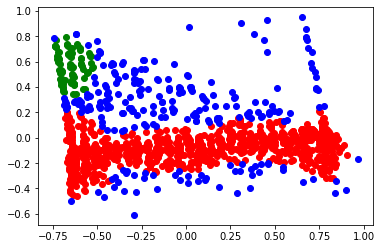

In [256]:
plotClusters(clusters_chosen_pca2)


###PCA alternativo kmeans 4D

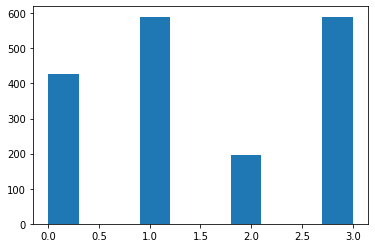

In [257]:
def kmeans_chosen_PCA(k):
  result2, centers2, c_aux2 = kMeans(out5d, k)
  histograma(result2)
  return centers2

centers_PCA_5D_k4 = kmeans_chosen_PCA(4)

###Aplicando PCA para 5D

In [258]:
def acharEpsM5D():
  list_erros=[]
  for i in range(1,10):
    for j in range(1,10):
      result, a, b = dbscan(out5d, 0.05*i, 10*j)
      n = len(result)
      print(i,j,n,len(result[n-1]))
      print("------------------")
#acharEpsM5D()

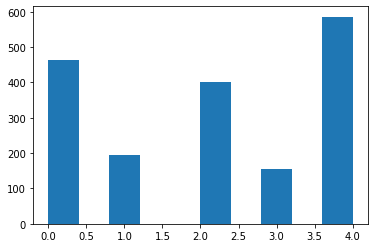

In [259]:
centers_PCA_5D_k5 = kmeans_chosen_PCA(5)

In [260]:
clusters_chosen_pca5, cores_chosen_pca5, eps_chosen_pca5 = dbscan(out5d, 0.25,70)

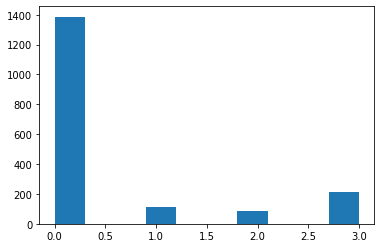

In [261]:
histograma(clusters_chosen_pca5)

##Testes dos treinamentos

###KMeans dataSet enunciado

In [262]:
def testKMeans2D(centers, pontos, maxAx):
  clustersPlot = []
  centers.transpose()
  cent_N = centers/maxAx
  cent_N.transpose()
  centers.transpose()
  for i in range(0, len(cent_N)):
    clustersPlot.append([])
  for i in range(0,len(pontos)):
    clustersPlot[menorDist(cent_N, pontos[i])].append(pontos[i])
  return clustersPlot

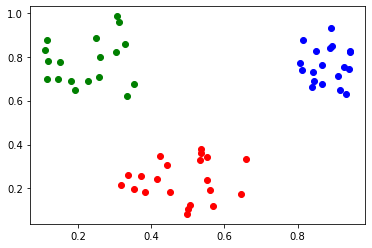

In [263]:
plotClusters(testKMeans2D(centers1, data_test_enun, maxAxis_enun))
plt.show()

###KMeans dataSet escolhido

10
10


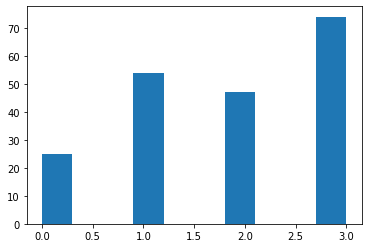

In [264]:
def testKMeansND(centers, pontos, maxAx):
  clustersPlot = []
  for i in range(0, len(centers)):
    centers[i] = centers[i]/maxAx
  cent_N = centers
  for i in range(0, len(cent_N)):
    clustersPlot.append([])
  for i in range(0,len(pontos)):
    #print(len(cent_N[0]), len(pontos[i]))
    clustersPlot[menorDist(cent_N, pontos[i])].append(pontos[i])
  return clustersPlot

print(len(centers2[0]))
print(len(data_test_chosen[0]))
histograma(testKMeansND(centers2, data_test_chosen,maxAxis_chosen))

###KMeans escolhido com uso de PCA 2D e 5D

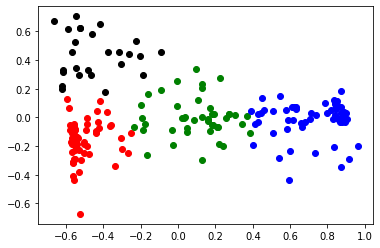

In [265]:
plotClusters(testKMeans2D(centers_PCA_2D,out2d_test,[1,1]))
plt.show()

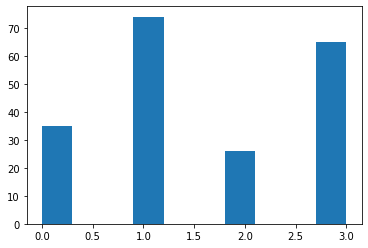

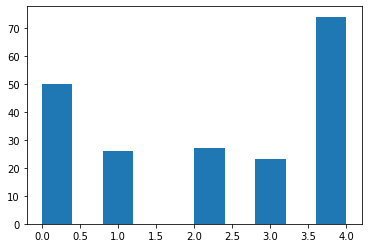

In [266]:
histograma(testKMeansND(centers_PCA_5D_k4, out5d_test, [1,1,1,1,1]))
histograma(testKMeansND(centers_PCA_5D_k5, out5d_test, [1,1,1,1,1]))

###DBSCAN dataSet enunciado

In [267]:
def clusteringDBSCAN(centros, p, eps):
    min = [0,3]
    for i in range(len(centros)):
      for j in range(len(centros[i])):
        d = dist(p, centros[i][j])
        if d < min[1]:
          min = [i, d]
    if(eps < min[1]):
        return len(centros)
    return min[0]

In [268]:
def testDBSCAN(cores, dataSet, eps):
  clustersPlot = []
  for i in range(0, 1 + len(cores)):
    clustersPlot.append([])
  for i in range(0,len(dataSet)):
    clustersPlot[clusteringDBSCAN(cores, dataSet[i], eps)].append(dataSet[i])
  return clustersPlot

    

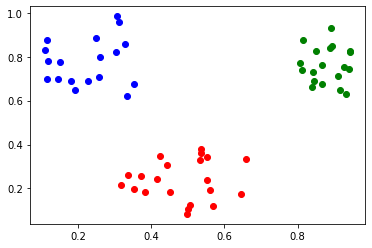

In [269]:
plotClusters(testDBSCAN(cores_enun, data_test_enun, eps_enun))

###DBSCAN dataSet escolhido

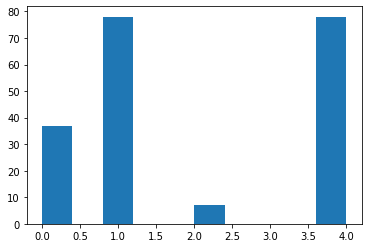

In [270]:
histograma(testDBSCAN(cores_chosen, data_test_chosen, eps_chosen))

###DBSCAN dataSet escolhido com uso de PCA 2D e 5D

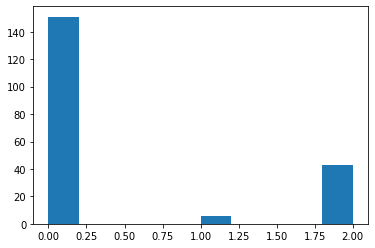

In [271]:
histograma(testDBSCAN(cores_chosen_pca2, out2d_test, eps_chosen_pca2))

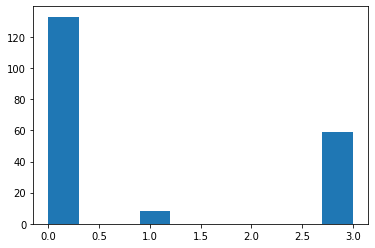

In [272]:
histograma(testDBSCAN(cores_chosen_pca5, out5d_test, eps_chosen_pca5))

##Discussão e análise

***1 ) How/if normalization affected your results.***

**R:** Supomos que todas as nossas features são de mesmo peso/importância, tanto no dataSet do enunciado quanto o escolhido. Além disso, nossos metodos em usam distância euclidiano, ou seja, os valores absulutos das features impactam drasticamente nosso modelo. Pensando nisso, features com escalas diferentes podem fazer com que as quais com maiores valors tenham maior importância/peso, assim nosso treinamento fica tendencioso para a tais fetures. Dessa forma, a normalização é fundamental, pois garantimos que as features possuam a mesma relevância no treinamento.

***2) If the number of clusters achieved is good representatives of your data.***

**R:** Primeiramente vamos falar do dataSet dado no trabalho. Nesse caso, é perceptível que 3 clusters é um bom valor. Ademais, usamos o método do cotovelo para validar em relação o K-means, e pelo método conseguimos ver que 3 de fato é bom. No DBSCAN com o dataSet dado, fomos mudando os parâmetros do método até encontrar uma boa divisão de clusters. Em relação o dataSet escolhido, também usamos o método do cotovelo para encontrar um bom k, usamos o k igual o 4, acreditamos que foi uma boa escolha, porque apesar do nosso dataSet estar com os pontos bem unidos, conseguimos visualizar uma divisão(principalmente usando o PCA para 2D) mais clara em 4 grupos. Em relação o uso do DBSCAN, escolhemos os parametros que tinham menos outliners e mais clusters possíveis, como nosso dataSet possui pontos bem unidos e bastantes outliners, nossos clusterizações com esse método se resumia a um único cluster ou inúmeros outliners e poucos clusterings. Apesar dessas adversidades, nosso DBSCAN conseguiu seperar de acordo com a desidade das regiões e separando os pontos mais isolados em outliner, não temos a resposta se foi uma boa clusterização, mas o método conseguiu encontrar clusters coerentes com o método.  

***3)How/if the initialization of cluster centers affected the solution.***

**R:** A inicialização pode afetar no tempo que leva para o treinamento convergir. É possível também que o treinamento fique preso em algum minimo local dependendo das inicializações. Como apresentado no inicio do notebook, no kmeans, testamos 3 metodos de inicialização e acabamos por optar pela inicialização que toma como mais provaveis os pontos mais distantes do centro atual e dando probabilidade 0 para pontos mais próximos. Fazendo assim com que sempre se escolha um ponto distante mas nem sempre o mais distante. O que acaba por reduzir o tempo de convergencia e a chance de o treinamento ficar preso em um minimo local. Vale lembrar também que existe o método de inicialização totalmente randomico onde são escolhidos k pontos aleatorios da amostra. Esse método é perigoso pois existe a chance de se escolher por exemplo dois pontos muito proximos de modo a fazer com que a clusterização não convirja para onde deveria.
Quanto ao DBSCAN, não há muito a se comentar quanto à inicialização uma vez que não há muitas opções conhecidas além da estândar.

***4)The advantages and disadvantages of each method.***

**R:**

**Vantagens kmeans:**

-É mais eficiente que o dbscan em datasets grandes

-A variação da densidade das amostras em determinados intervalos não afeta o algoritmo enquanto afeta bastante o dbscan

**Vantagens dbscan:**

-Ao contrário do kmeans, funciona bem em datasets com formas não convexas

-Trata bem os outliers enquanto o kmeans apenas os inclui em algum cluster

Vale ressaltar que o melhor método depende do tipo do problema. Embora possuam caracteristicas diferentes, não há um método absolutamente melhor que o outro. Como apresentado acima na lista de vantagens, o DBSCAN trabalha observando a densidade de pontos enquanto que o kmeans não leva isso em conta, o que inclusive pode ser bom em alguns datasets. Mas por outro lado se existe algum tipo de dado com cluster de representação não convexa no dataset, o DBSCAN apresenta desempenho muito superior.

Observando o dataset por nós escolhido, como não sabemos ao certo o formato de clusterização esperado para nossos dados, não conseguimos afirmar que o kmeans ou o DBSCAN nos apresentou um resultado mais próximo à realidade dos dados. Mas o que podemos observar principalmente relativo à redução de dimensionalidade para 2D é que o tipo de dado que estava sendo tratado possuía pontos de alta densidade e varios outliers. O que pode ser um indicio de que o dataset se adeque melhor ao DBSCAN uma vez que esse faz sua busca com base na densidade e da um tratamento específico aos outliers, coisas que o kmeans não faz. 

Com o dataset escolhido, pudemos verificar bem as propriedades dos dois métodos durante o processo de clusterização nos trazendo maior compreensão das situações para as quais cada um se aplica.

***5)How dimensionality reduction affected your results***

**R:** Como o dataset por nós escolhido para a segunda parte possuia bastante dimensões, a redução de dimensionalidade se mostrou como uma parte muito importante do desenvolvimento do nosso trabalho. Primeiramente enquanto realizando os treinamentos sem redução de dimensionalidade, para se fazer as comparações, optamos por fazer o histograma dos clusters de treinamento e comparar com o histograma dos pontos de teste após classifica-los nos seus respectivos clusters e assumindo uma distribuição semelhante no conjunto de treinamento e de teste era esperado que os histogramas possuissem formas semelhantes, o que pode ser observado nos exemplos ao longo do notebook. Após os testes feitos sem a redução de dimensionalidade, fizemos novos testes reduzindo as features para um espaço com cinco dimensões e com duas dimensões. Quando feita para cinco dimensões, ainda se tornou necessário a vizualização através do histograma e não através de uma representação geométrica. Mas quando feita a redução para duas dimensões, foi possível se observar de forma muito mais clara a natureza dos dados. Um ponto interessante a se observar é que a mudança de dimensionalidade para a execução do kmeans manteve o mesmo parametro k e apresentou um grafico de cotovelo bem semelhante se não identico. Enquanto que a redução de dimensão para a execução do DBSCAN nos fez fazer algumas mudanças nos valores de epslon e de M. A redução de dimensionalidade além de permitir uma sintetização e simplificação dos dados, também atua de modo a reduzir o tempo de processamento para se executar os treinamentos e os testes, uma vez que se é possível reduzir significativamente o tamanho dos dados de entrada.

##Divisão do trabalho

Basicamente o Gustavo fez a parte com KMeans e testes, e o Hitalo trabalhou com o DBSCAN. Entretanto, boa parte do trabalho oi feito em conjunto em calls e um sabia como implementar a parte do outro para se ajudarem. Ao decorrer do trabalho foi feita várias funções auxiliares, as quais não lembramos quão cada um contribuiu para atribuir quem fez tais funções.